In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform, filters
import sys, pylab, operator, csv
import util
import os
import urllib
%matplotlib inline

caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
sys.path.insert(0, caffe_root + 'python')

import caffe

[('n02483362 gibbon', 0.81853402), ('n02457408 three-toed sloth', 0.055385757), ('n02497673 Madagascar cat', 0.025178645), ('n02490219 marmoset', 0.02405569), ('n02500267 indri', 0.01478431)]


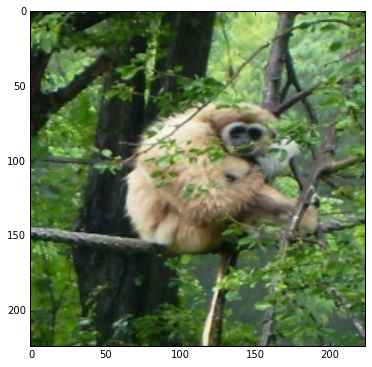

In [2]:
caffe.set_mode_cpu()
net = caffe.Net('../models/VGG16/VGG_ILSVRC_16_layers_deploy_bp.prototxt',
                '../models/VGG16/VGG_ILSVRC_16_layers_bp.caffemodel',
                caffe.TRAIN)
tags,tag2ID = util.loadTags('../data/ilsvrc12/synset_words.txt')
param = dict()
imgScale = 224
topBlobName = 'fc8_bp'
topLayerName = 'fc8_bp'
fwdLayerName = 'prob'
secondTopBlobName = 'fc7_bp'
secondTopLayerName = 'fc7_bp'


imgName = '/data1/imagenet-data/raw-data/validation/n02483362/ILSVRC2012_val_00028219.JPEG'
img = caffe.io.load_image(imgName)
minDim = min(img.shape[:2])

newSize = (imgScale,imgScale)
imgS = transform.resize(img, newSize)
pylab.rcParams['figure.figsize'] = (6.0, 6.0)
plt.imshow(imgS)


net.blobs['data'].reshape(1,3,newSize[0],newSize[1])
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_mean('data', np.array([103.939, 116.779, 123.68]))
transformer.set_transpose('data', (2,0,1))
transformer.set_channel_swap('data', (2,1,0))
transformer.set_raw_scale('data', 255.0)

net.blobs['data'].data[...] = transformer.preprocess('data', imgS)
out = net.forward(end = fwdLayerName)

scores = net.blobs[topBlobName].data[0].reshape((len(tags),-1)).max(1).flatten() # pre-softmax scores
tagScore = util.getTagScore(scores, tags, tag2ID)
tagScore.sort(key = operator.itemgetter(1), reverse = True)
topScores = tagScore[:5]
print(topScores)




(512, 14, 14)
(512, 14, 14)
(512, 14, 14)


/usr/local/lib/python2.7/dist-packages/skimage/_shared/utils.py:174: skimage_deprecation: Mode 'nearest' has been renamed to 'edge'. Mode 'nearest' will be removed in a future release.
  "Mode 'nearest' has been renamed to 'edge'. Mode 'nearest' will be "


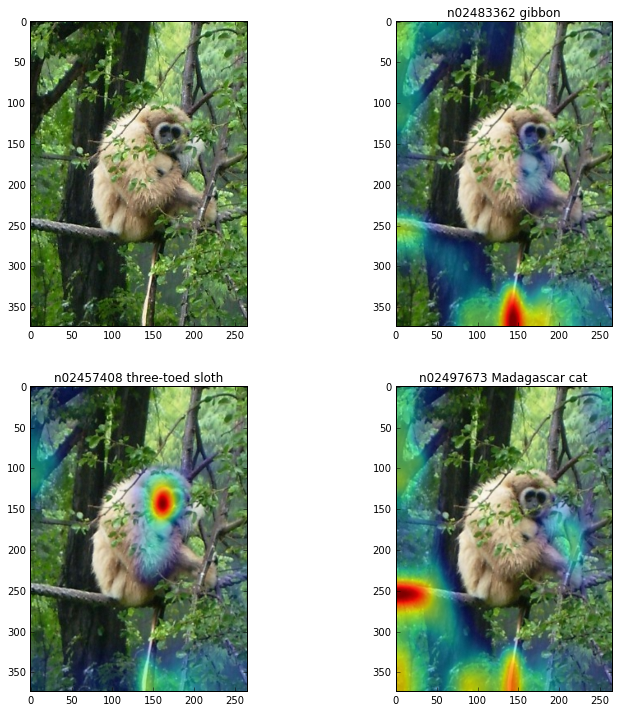

In [3]:
# switch to the excitation backprop mode
caffe.set_mode_eb_cpu() 
# specify the tags
tagName = ['n02483362 gibbon','n02457408 three-toed sloth','n02497673 Madagascar cat']
#specify the output layer name
outputLayerName = 'pool4'#'inception_5b/output'
outputBlobName = 'pool4'#'inception_5b/output'

attMaps = []

for i in range(len(tagName)):
    tagID = tag2ID[tagName[i]]
    net.blobs[topBlobName].diff[0][...] = 0
    net.blobs[topBlobName].diff[0][tagID] = np.exp(net.blobs[topBlobName].data[0][tagID].copy())
    net.blobs[topBlobName].diff[0][tagID] /= net.blobs[topBlobName].diff[0][tagID].sum()

    # invert the top layer weights
    net.params[topLayerName][0].data[...] *= -1
    out = net.backward(start = topLayerName, end = secondTopLayerName)
    buff = net.blobs[secondTopBlobName].diff.copy()

    # invert back
    net.params[topLayerName][0].data[...] *= -1 
    out = net.backward(start = topLayerName, end = secondTopLayerName)

    # compute the contrastive signal
    net.blobs[secondTopBlobName].diff[...] -= buff

    out = net.backward(start = secondTopLayerName, end = outputLayerName)
    attMap = np.maximum(net.blobs[outputBlobName].diff[0].sum(0), 0)
    attMaps.append(attMap)

util.showAttMap(img, attMaps, tagName, overlap = True, blur = False)


In [4]:
# specify the tags
caffe.set_mode_eb_cpu() 
tagName = ['n02483362 gibbon']
#specify the output layer name
topBlobName = 'fc8_bp'
topLayerName = 'fc8_bp'
fwdLayerName = 'prob'
secondTopBlobName = 'fc7_bp'
secondTopLayerName = 'fc7_bp'

outputLayerName = 'pool4'#'inception_5b/output'
outputBlobName = 'pool4'#'inception_5b/output'

attMaps = []


tagID = tag2ID['n02483362 gibbon']
net.blobs[topBlobName].diff[0][...] = 0
net.blobs[topBlobName].diff[0][tagID] = 1; # np.exp(net.blobs[topBlobName].data[0][tagID].copy())
# net.blobs[topBlobName].diff[0][tagID] /= net.blobs[topBlobName].diff[0][tagID].sum()

# invert the top layer weights
if False:
    out = net.backward(start = fwdLayerName, end = outputLayerName)
    buff = net.blobs[secondTopBlobName].diff.copy()

else:


    net.params[topLayerName][0].data[...] *= -1
    out = net.backward(start = topLayerName, end = secondTopLayerName)
    buff = net.blobs[secondTopBlobName].diff.copy()
    # invert back
    net.params[topLayerName][0].data[...] *= -1 
    out = net.backward(start = topLayerName, end = secondTopLayerName)
    # compute the contrastive signal
    net.blobs[secondTopBlobName].diff[...] -= buff

    out = net.backward(start = secondTopLayerName, end = outputLayerName)


select_bp_gt = net.blobs['fc8_bp'].diff[0].flatten()
print "select_bp_gt shape:" + str(select_bp_gt.shape)

fc8_fw_gt = net.blobs['fc7_bp'].diff[0].flatten()
print "fc8_fw_gt shape:" + str(fc8_fw_gt.shape)

fc7_fw_gt = net.blobs['fc6_bp'].diff[0].flatten()
print "fc7_fw_gt shape:" + str(fc7_fw_gt.shape)

fc6_fw_gt = net.blobs['pool5'].diff[0].flatten()
print "fc6_fw_gt shape:" + str(fc6_fw_gt.shape)


conv5_3_fw_gt = net.blobs['conv5_2'].diff[0].flatten()
print "conv5_3_fw_gt shape:" + str(conv5_3_fw_gt.shape)

conv5_2_fw_gt = net.blobs['conv5_1'].diff[0].flatten()
print "conv5_2_fw_gt shape:" + str(conv5_2_fw_gt.shape)


conv5_1_fw_gt = net.blobs['pool4'].diff[0].flatten()
print "conv5_1_fw_gt shape:" + str(conv5_1_fw_gt.shape)

select_bp_gt shape:(1000,)
fc8_fw_gt shape:(4096,)
fc7_fw_gt shape:(4096,)
fc6_fw_gt shape:(25088,)
conv5_3_fw_gt shape:(100352,)
conv5_2_fw_gt shape:(100352,)
conv5_1_fw_gt shape:(100352,)


In [5]:
print fc8_fw_gt.sum()

-2.23517e-08


In [15]:
caffe.set_mode_cpu()
net1 = caffe.Net('../models/ccs_bp/ccs_bp_contrastive.prototxt',
                '../models/VGG16/VGG_ILSVRC_16_layers_bp.caffemodel',
                caffe.TRAIN)
tags,tag2ID = util.loadTags('../data/ilsvrc12/synset_words.txt')
param = dict()


In [16]:
imgScale = 224
topBlobName = 'fc8_bp'
topLayerName = 'fc8_bp'
forwardtoLayerName = 'fc8_diff'
forwardtoBlobName = 'select_bp'

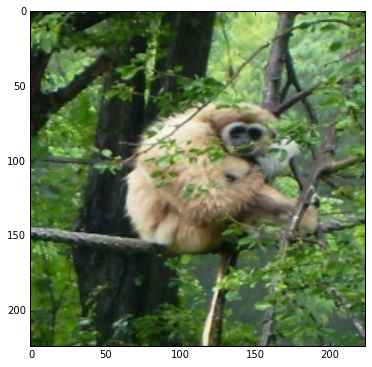

In [17]:
imgName = '/data1/imagenet-data/raw-data/validation/n02483362/ILSVRC2012_val_00028219.JPEG'
img = caffe.io.load_image(imgName)
minDim = min(img.shape[:2])

newSize = (imgScale,imgScale)
imgS = transform.resize(img, newSize)
pylab.rcParams['figure.figsize'] = (6.0, 6.0)
plt.imshow(imgS)

In [18]:
caffe.set_mode_cpu()
net1.blobs['data'].reshape(1,3,newSize[0],newSize[1])
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_mean('data', np.array([103.939, 116.779, 123.68]))
transformer.set_transpose('data', (2,0,1))
transformer.set_channel_swap('data', (2,1,0))
transformer.set_raw_scale('data', 255.0)

net1.params["fc8_diff_cont"][0].data[...] = net1.params["fc8_diff"][0].data
net1.params["fc8_diff_cont"][0].data[...] *= -1

net1.blobs['data'].data[...] = transformer.preprocess('data', imgS)
out = net1.forward(end = "conv5_1_diff")

scores = net1.blobs[topBlobName].data[0].reshape((len(tags),-1)).max(1).flatten() # pre-softmax scores
tagScore = util.getTagScore(scores, tags, tag2ID)
tagScore.sort(key = operator.itemgetter(1), reverse = True)
print(tagScore[:10])

[('n02483362 gibbon', 0.81853402), ('n02457408 three-toed sloth', 0.055385757), ('n02497673 Madagascar cat', 0.025178645), ('n02490219 marmoset', 0.02405569), ('n02500267 indri', 0.01478431), ('n02510455 giant panda', 0.0074728783), ('n02488291 langur', 0.0073625459), ('n02493509 titi', 0.0073336256), ('n02493793 spider monkey', 0.0063641001), ('n01622779 great grey owl', 0.0045674993)]


In [19]:
select_bp = net1.blobs["select_bp"].data[0].flatten()
print "shape of select_bp:" + str(select_bp.shape)
print "checking select bp:" + str(np.array_equal(select_bp,select_bp_gt))

fc8_fw = net1.blobs["fc8_diff_final"].data[0].flatten()
print "shape of fc8_diff:" + str(fc8_fw.shape)
print "checking fc8_diff:" + str(np.array_equal(fc8_fw,fc8_fw_gt))

fc7_fw = net1.blobs["fc7_diff"].data[0].flatten()
print "shape of fc7_diff:" + str(fc7_fw.shape)
print "checking fc7_diff:" + str(np.array_equal(fc7_fw,fc7_fw_gt))


fc6_fw = net1.blobs["fc6_diff_reshaped"].data[0].flatten()
print "shape of fc6_diff:" + str(fc6_fw.shape)
print "checking fc6_diff:" + str(np.array_equal(fc6_fw,fc6_fw_gt))

conv5_3_fw = net1.blobs["conv5_3_diff"].data[0].flatten()
print "shape of conv5_3_fw:" + str(conv5_3_fw.shape)
print "checking conv5_3_fw:" + str(np.array_equal(conv5_3_fw,conv5_3_fw_gt))

conv5_2_fw = net1.blobs["conv5_2_diff"].data[0].flatten()
print "shape of conv5_2_fw:" + str(conv5_2_fw.shape)
print "checking conv5_2_fw:" + str(np.array_equal(conv5_2_fw,conv5_2_fw_gt))


conv5_1_fw = net1.blobs["conv5_1_diff"].data[0].flatten()
print "shape of conv5_1_fw:" + str(conv5_1_fw.shape)
print "checking conv5_1_fw:" + str(np.array_equal(conv5_1_fw,conv5_1_fw_gt))


shape of select_bp:(1000,)
checking select bp:True
shape of fc8_diff:(4096,)
checking fc8_diff:True
shape of fc7_diff:(4096,)
checking fc7_diff:True
shape of fc6_diff:(25088,)
checking fc6_diff:True
shape of conv5_3_fw:(100352,)
checking conv5_3_fw:True
shape of conv5_2_fw:(100352,)
checking conv5_2_fw:True
shape of conv5_1_fw:(100352,)
checking conv5_1_fw:True


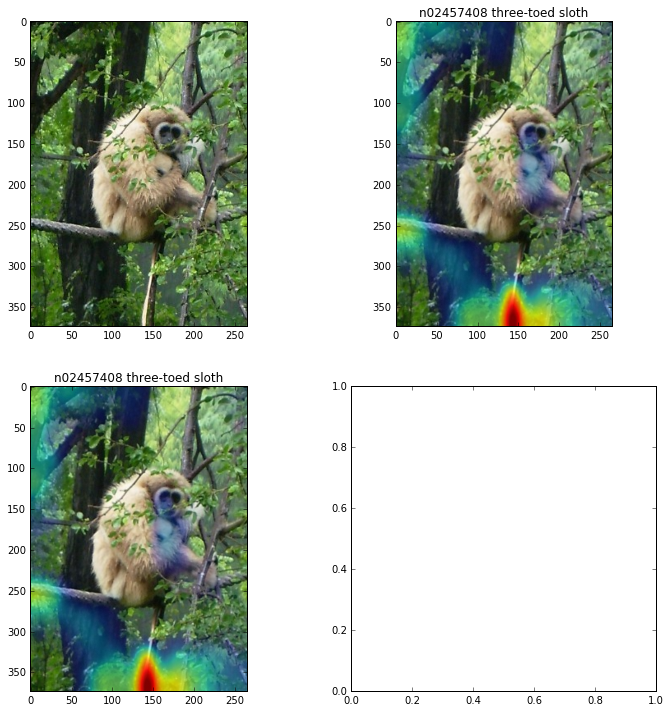

In [21]:
caffe.set_mode_cpu()
tagName = ['n02457408 three-toed sloth','n02457408 three-toed sloth']

attMaps = []

net1.params["fc8_diff_cont"][0].data[...] = net1.params["fc8_diff"][0].data
net1.params["fc8_diff_cont"][0].data[...] *= -1

for i in range(len(tagName)):
    tagID = tag2ID[tagName[i]]
    net1.blobs["fc8_diff_cont"].diff[0][...] = 0
    net1.blobs["fc8_diff_cont"].diff[0][tagID] = 1

    net1.blobs['data'].data[...] = transformer.preprocess('data', imgS)
    out = net1.forward(end = "conv5_1_diff")

    attMap = np.maximum(net1.blobs["conv5_1_diff"].data[0].sum(0), 0)
    attMaps.append(attMap)
util.showAttMap(img, attMaps, tagName, overlap = True, blur = False)